In [18]:
%matplotlib inline

In [19]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
import sys, os
import csv
import datetime
import numpy as np
import netCDF4
import ast
#import scipy.stats
#import json

import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt

import selection_criteria as s_c

In [21]:
def ts_to_dt(ts):
    return datetime.datetime.utcfromtimestamp(ts)
def dt_to_ts(dt):
    return (dt - datetime.datetime(1970, 1, 1)).total_seconds()


toarray = lambda s: np.array(ast.literal_eval(s))

# seifert setting for not embedding fonts
plt.rcParams['svg.fonttype'] = 'none'


In [22]:
filename = {
    "Pun_larda3": '../cloud_collections/cloud_collection_lacros_dacapo_all.csv',
    "Lim_larda3": '../cloud_collections/cloud_collection_lacros_cycare_all.csv',
    "Lei_larda3": '../cloud_collections/cloud_collection_lacros_leipzig_all.csv',
}

#
# including the fixed height sampling

filename = {
    "Pun_larda3": '../cloud_collections/cloud_collection_lacros_dacapo_all_incl_fixed.csv',
    "Lim_larda3": '../cloud_collections/cloud_collection_lacros_cycare_all_incl_fixed.csv',
    "Lei_larda3": '../cloud_collections/cloud_collection_lacros_leipzig_all_incl_fixed.csv',
}

# camp = "Lim_larda2"
# camp = "Pun_larda2"
# camp = "Pun_larda3"
# camp = "Lim_larda3"

#season = 'warm'
#season = 'cold'
season = 'all'

# the fraction of ice-forming clouds statistics (reproduce kanitz statistic)

In [23]:
def print_cloud_props(cloud):
    dt_begin = ts_to_dt(float(cloud['Begin_Date_Unix']))
    dt_end = ts_to_dt(float(cloud['End_Date_Unix']))
    iwc_n = float(cloud['IWC_TOP_N'])
    n_prof = float(cloud['N_Profiles'])
    print(dt_begin.strftime("%Y%m%d-%H%M"), '-', dt_end.strftime("%Y%m%d-%H%M"), ':', 
              "{:>7.1f}".format(float(cloud['CBH'])), "{:>7.1f}".format(float(cloud['CTH'])), 
              "{:>7.2f}".format(float(cloud['CTT'])-273.15), 
              "  {:.2e}".format(float(cloud['IWC_TOP_MED'])), 
              "  {:.2f}".format(iwc_n/n_prof),
             cloud['Cloud_Run'], cloud['Cloud_Type'])


def load_data(filename):
    data = []
    with open(filename, 'r') as f:
    #with open('cloud_collection_LEIPZIG_all.csv', 'r') as f:
        reader = csv.reader(f, delimiter=';')
        header = next(reader)
        for row in reader:
            #data.append(row)
            comp = row[1].replace('_', '')
            if row[0][:14] == comp:
                data.append({k:v for k, v in zip(header, row)})
            else:
                print('corrupted row ', row)
                break
                
    return data




# last one 1.5
#def make_kanitz_stat(data, alpha_hogan=1.5e-5, autocorr_thres=3e2, silent=False, season='all'):
#2021-01-17: changes for the new dataset with the 'improved' backscatter calibration
def make_kanitz_stat(
    data, 
    alpha_hogan=1.18e-5, autocorr_thres=3e2, cbh_thres=2000,
    z_thres=-30,
    silent=False, season='all'):
    
    clouds_standard = {
        'layered_all': [],
        'liquid_only': [],
        'ice_producing': []
    }

    for i, cloud in enumerate(data[:]):
        ffcloud = lambda s: float(cloud[s])
    
        dt_begin = ts_to_dt(ffcloud('Begin_Date_Unix'))
        dt_end = ts_to_dt(ffcloud('End_Date_Unix'))
        duration = dt_end-dt_begin

        conds = s_c.standard(cloud)

        if season == 'warm':
            conds += [dt_begin.month in [10,11,12,1,2,3], f"{dt_begin.month}, warm"]
            # xiandas dates
            #conds += [dt_begin.month in [10,11,12,1,2], f"{dt_begin.month}, warm"]
        elif season == 'cold':
            conds += [dt_begin.month in [4,5,6,7,8,9], f"{dt_begin.month}, cold"]
            # xiandas dates
            #conds += [dt_begin.month in [5,6,7,8,9], f"{dt_begin.month}, cold"]
        
        
        print(all(conds[::2]), "   ", " ".join(conds[1::2])) if not silent else None
        #print(dt_begin, '-', dt_end, ':', h_base, h_top, conds)
        #if cloud["Cloud_Run"] == 'mixed-phase':
            #print(conds)
            #print(cloud['A_Unique_Identifier'] + " critera not matched: " + "   ".join([t for c, t in zip(conds, conds_text) if not c]))
            #print("duration", duration, 'htop', h_top, 'sigma_thick', sigma_thick)
            #print(cloud["Cloud_Run"], 'prof', n_prof, duration.seconds/30,'sigma_cth', sigma_cth, 'iwc_n', iwc_n)

        if all(conds[::2]):
            #print('cloud keys', cloud.keys())

            print_cloud_props(cloud) if not silent else None
    #         print("     DL {}".format(cloud['v_dl_n']),
    #               "{:>6.2f}".format(float(cloud['v_dl_mean'])), 
    #               "{:>6.2f}".format(float(cloud['v_dl_std'])), 
    #               "{:>6.2f}".format(float(cloud['v_dl_skew'])), 
    #               " Perc ", " ".join(["{:>5.2f}".format(float(d)) for d in ast.literal_eval(cloud['v_dl_perc'])]))
    #         print("     CR {}".format(cloud['v_cr_n']),
    #               "{:>6.2f}".format(float(cloud['v_cr_mean'])), 
    #               "{:>6.2f}".format(float(cloud['v_cr_std'])), 
    #               "{:>6.2f}".format(float(cloud['v_cr_skew'])), 
    #               " Perc ", " ".join(["{:>5.2f}".format(float(d)) for d in ast.literal_eval(cloud['v_cr_perc'])]))
            clouds_standard['layered_all'].append(cloud)
            if ffcloud('IWC_TOP_N')/ffcloud('N_Profiles') < 0.05:
                clouds_standard['liquid_only'].append(cloud)
                if float(cloud['CTT'])-273.15 < -20:
                    print("     DL {}".format(cloud['v_dl_n']),
                      "{:>6.2f}".format(float(cloud['v_dl_mean'])), 
                      #"{:>6.2f}".format(float(cloud['v_dl_std'])), 
                      "{:>6.2f}".format(float(cloud['v_dl_skew'])), 
                      cloud['v_dl_perc']) if not silent else None
                      #" Perc ", " ".join(["{:>5.2f}".format(float(d)) for d in ast.literal_eval(cloud['v_dl_perc'])]))
            else:
                if float(cloud['CTT'])-273.15 > -10:
                    print("a warm one") if not silent else None
                elif float(cloud['CTT'])-273.15 < -20 and float(cloud['CBH']) < 2000:
                    print("low base and cold") if not silent else None
                    #raise ValueError
                clouds_standard['ice_producing'].append(cloud)
                
    clouds_above_cbh_thres = {
        'layered_all': [],
        'liquid_only': [],
        'ice_producing': []
    }

    for i, cloud in enumerate(data[:]):
        ffcloud = lambda s: float(cloud[s])
    
        dt_begin = ts_to_dt(ffcloud('Begin_Date_Unix'))
        dt_end = ts_to_dt(ffcloud('End_Date_Unix'))
        duration = dt_end-dt_begin

#         conds = [duration > datetime.timedelta(seconds=20*60), f"{duration}",
#                  ffcloud('N_Profiles')/(duration.seconds/30.) > 0.8, f"{ffcloud('N_Profiles')*30/duration.seconds:.3f}",
#                  cloud['Cloud_Run'] in ['layered'], f"{cloud['Cloud_Run']}",
#                  ffcloud('Cloud_Thickness_MED') < 350, f"{ffcloud('Cloud_Thickness_MED'):.1f}",
#                  ffcloud('CTH_STD') < 150, f"{ffcloud('CTH_STD'):.1f}",
#                  ffcloud('CBH') > 2000, f"{ffcloud('CBH'):.1f}",
#                 ]
        conds = s_c.with_gt_cbh(cloud, cbh_thres)

        if all(conds[::2]):
            clouds_above_cbh_thres['layered_all'].append(cloud)
            if ffcloud('IWC_TOP_N')/ffcloud('N_Profiles') < 0.05:
                clouds_above_cbh_thres['liquid_only'].append(cloud)
            else:
                clouds_above_cbh_thres['ice_producing'].append(cloud)
                
    clouds_below_cbh_thres = {
        'layered_all': [],
        'liquid_only': [],
        'ice_producing': []
    }

    for i, cloud in enumerate(data[:]):
        ffcloud = lambda s: float(cloud[s])
    
        dt_begin = ts_to_dt(ffcloud('Begin_Date_Unix'))
        dt_end = ts_to_dt(ffcloud('End_Date_Unix'))
        duration = dt_end-dt_begin

#         conds = [duration > datetime.timedelta(seconds=20*60), f"{duration}",
#                  ffcloud('N_Profiles')/(duration.seconds/30.) > 0.8, f"{ffcloud('N_Profiles')*30/duration.seconds:.3f}",
#                  cloud['Cloud_Run'] in ['layered'], f"{cloud['Cloud_Run']}",
#                  ffcloud('Cloud_Thickness_MED') < 350, f"{ffcloud('Cloud_Thickness_MED'):.1f}",
#                  ffcloud('CTH_STD') < 150, f"{ffcloud('CTH_STD'):.1f}",
#                  ffcloud('CBH') < 2000, f"{ffcloud('CBH'):.1f}",
#                 ]
        conds = s_c.with_lt_cbh(cloud, cbh_thres)

        if all(conds[::2]):
            clouds_below_cbh_thres['layered_all'].append(cloud)
            if ffcloud('IWC_TOP_N')/ffcloud('N_Profiles') < 0.05:
                clouds_below_cbh_thres['liquid_only'].append(cloud)
            else:
                clouds_below_cbh_thres['ice_producing'].append(cloud)
                
                
#     clouds_above_2km_not_wave = {
#         'layered_all': [],
#         'liquid_only': [],
#         'ice_producing': []
#     }

#     for i, cloud in enumerate(data[:]):
#         ffcloud = lambda s: float(cloud[s])
    
#         dt_begin = ts_to_dt(ffcloud('Begin_Date_Unix'))
#         dt_end = ts_to_dt(ffcloud('End_Date_Unix'))
#         duration = dt_end-dt_begin
        
#         v_dl_perc = ast.literal_eval(cloud['v_dl_perc'])
#         if type(v_dl_perc) is not list:
#             v_dl_perc = [-99, -99, -99, -99]

#         conds = [duration > datetime.timedelta(seconds=20*60), f"{duration}",
#                  ffcloud('N_Profiles')/(duration.seconds/30.) > 0.8, f"{ffcloud('N_Profiles')*30/duration.seconds:.3f}",
#                  cloud['Cloud_Run'] in ['layered'], f"{cloud['Cloud_Run']}",
#                  ffcloud('Cloud_Thickness_MED') < 350, f"{ffcloud('Cloud_Thickness_MED'):.1f}",
#                  ffcloud('CTH_STD') < 150, f"{ffcloud('CTH_STD'):.1f}",
#                  ffcloud('CBH') > 2000, f"{ffcloud('CBH'):.1f}",
#                  float(v_dl_perc[3]) < 0.7, f"{float(v_dl_perc[3]):.3f}",
#                  float(v_dl_perc[3]) > -90, f"{float(v_dl_perc[3]):.3f}",
#                 ]

#         if all(conds[::2]):
#             clouds_above_2km_not_wave['layered_all'].append(cloud)
#             if ffcloud('IWC_TOP_N')/ffcloud('N_Profiles') < 0.05:
#                 clouds_above_2km_not_wave['liquid_only'].append(cloud)
#             else:
#                 clouds_above_2km_not_wave['ice_producing'].append(cloud)
            
    not_wave = {
        'layered_all': [],
        'liquid_only': [],
        'ice_producing': []
    }

    for i, cloud in enumerate(data[:]):
        ffcloud = lambda s: float(cloud[s])
    
        dt_begin = ts_to_dt(ffcloud('Begin_Date_Unix'))
        dt_end = ts_to_dt(ffcloud('End_Date_Unix'))
        duration = dt_end-dt_begin
          
        #conds = s_c.not_wave(cloud, autocorr_thres)
        conds = s_c.not_wave_fixh(cloud, autocorr_thres)

        if all(conds[::2]) and 'v_dl_fix_autocor_time' in cloud and len(cloud['v_dl_fix_autocor_time']) > 5:
        #if all(conds[::2]) and 'v_dl_autocor_time' in cloud and len(cloud['v_dl_autocor_time']) > 5:
            not_wave['layered_all'].append(cloud)
            if ffcloud('IWC_TOP_N')/ffcloud('N_Profiles') < 0.05:
                not_wave['liquid_only'].append(cloud)
            else:
                not_wave['ice_producing'].append(cloud)
                
    not_wave_above_cbh = {
        'layered_all': [],
        'liquid_only': [],
        'ice_producing': []
    }

    for i, cloud in enumerate(data[:]):
        ffcloud = lambda s: float(cloud[s])
    
        dt_begin = ts_to_dt(ffcloud('Begin_Date_Unix'))
        dt_end = ts_to_dt(ffcloud('End_Date_Unix'))
        duration = dt_end-dt_begin
          
        #conds = s_c.not_wave(cloud, autocorr_thres)
        conds = s_c.not_wave_fixh(cloud, autocorr_thres)
        conds += s_c.with_gt_cbh(cloud, cbh_thres)

        #if all(conds[::2]) and 'v_dl_autocor_time' in cloud and len(cloud['v_dl_autocor_time']) > 5:
        if all(conds[::2]) and 'v_dl_fix_autocor_time' in cloud and len(cloud['v_dl_fix_autocor_time']) > 5:
            not_wave_above_cbh['layered_all'].append(cloud)
            if ffcloud('IWC_TOP_N')/ffcloud('N_Profiles') < 0.05:
                not_wave_above_cbh['liquid_only'].append(cloud)
            else:
                not_wave_above_cbh['ice_producing'].append(cloud)
                
    above_Z = {
        'layered_all': [],
        'liquid_only': [],
        'ice_producing': []
    }

    for i, cloud in enumerate(data[:]):
        ffcloud = lambda s: float(cloud[s])
    
        dt_begin = ts_to_dt(ffcloud('Begin_Date_Unix'))
        dt_end = ts_to_dt(ffcloud('End_Date_Unix'))
        duration = dt_end-dt_begin
        
#         iwc_n = float(cloud['IWC_TOP_N'])
#         iwc_top_med = float(cloud['IWC_TOP_MED'])
#         iwc_med = float(cloud['IWC_MED'])
        v_dl_perc = ast.literal_eval(cloud['v_dl_perc'])
        if type(v_dl_perc) is not list:
            v_dl_perc = [-99, -99, -99, -99]

        conds = s_c.standard(cloud)
            
        if all(conds[::2]):
            above_Z['layered_all'].append(cloud)
            #print(iwc_top_med)
            #if iwc_n/n_prof > 0.05 and iwc_top_med > 3e-7:
            if ffcloud('IWC_TOP_N')/ffcloud('N_Profiles') > 0.05 and ffcloud('Z_TOP_AVG') > 10**(z_thres/10.):
                above_Z['ice_producing'].append(cloud)
            else:
                above_Z['liquid_only'].append(cloud)
                
    above_alpha_hogan = {
        'layered_all': [],
        'liquid_only': [],
        'ice_producing': []
    }

    for i, cloud in enumerate(data[:]):
        ffcloud = lambda s: float(cloud[s])
    
        dt_begin = ts_to_dt(ffcloud('Begin_Date_Unix'))
        dt_end = ts_to_dt(ffcloud('End_Date_Unix'))
        duration = dt_end-dt_begin
        
#         iwc_n = float(cloud['IWC_TOP_N'])
#         iwc_top_med = float(cloud['IWC_TOP_MED'])
#         iwc_med = float(cloud['IWC_MED'])
        v_dl_perc = ast.literal_eval(cloud['v_dl_perc'])
        if type(v_dl_perc) is not list:
            v_dl_perc = [-99, -99, -99, -99]

        conds = s_c.standard(cloud)
            
        if all(conds[::2]):
            above_alpha_hogan['layered_all'].append(cloud)
            #print(iwc_top_med)
            #if iwc_n/n_prof > 0.05 and iwc_top_med > 3e-7:
            if ffcloud('IWC_TOP_N')/ffcloud('N_Profiles') > 0.05 and ffcloud('alpha_Hogan_MED') > alpha_hogan:
                above_alpha_hogan['ice_producing'].append(cloud)
            else:
                above_alpha_hogan['liquid_only'].append(cloud)
                
                
    above_cbh_above_alpha_hogan = {
        'layered_all': [],
        'liquid_only': [],
        'ice_producing': []
    }

    for i, cloud in enumerate(data[:]):
        ffcloud = lambda s: float(cloud[s])
    
        dt_begin = ts_to_dt(ffcloud('Begin_Date_Unix'))
        dt_end = ts_to_dt(ffcloud('End_Date_Unix'))
        duration = dt_end-dt_begin
        
        conds = s_c.with_gt_cbh(cloud, cbh_thres)
        
        if all(conds[::2]):
            above_cbh_above_alpha_hogan['layered_all'].append(cloud)
            #print(iwc_top_med)
            #if iwc_n/n_prof > 0.05 and iwc_top_med > 3e-7:
            if ffcloud('IWC_TOP_N')/ffcloud('N_Profiles') > 0.05 and ffcloud('alpha_Hogan_MED') > alpha_hogan:
                above_cbh_above_alpha_hogan['ice_producing'].append(cloud)
            else:
                above_cbh_above_alpha_hogan['liquid_only'].append(cloud)

    not_wave_above_alpha_hogan = {
        'layered_all': [],
        'liquid_only': [],
        'ice_producing': []
    }

    for i, cloud in enumerate(data[:]):
        ffcloud = lambda s: float(cloud[s])
    
        dt_begin = ts_to_dt(ffcloud('Begin_Date_Unix'))
        dt_end = ts_to_dt(ffcloud('End_Date_Unix'))
        duration = dt_end-dt_begin
            
        #conds = s_c.not_wave(cloud, autocorr_thres)
        conds = s_c.not_wave_fixh(cloud, autocorr_thres)
        
        if all(conds[::2]) and 'v_dl_autocor_time' in cloud and len(cloud['v_dl_autocor_time']) > 5:
            not_wave['layered_all'].append(cloud)
            if ffcloud('IWC_TOP_N')/ffcloud('N_Profiles') > 0.05 and ffcloud('alpha_Hogan_MED') > alpha_hogan:
                not_wave_above_alpha_hogan['ice_producing'].append(cloud)
            else:
                not_wave_above_alpha_hogan['liquid_only'].append(cloud)
                
                

    
    return {'clouds_standard': clouds_standard, 
            'clouds_above_cbh_thres': clouds_above_cbh_thres, 
            'clouds_below_cbh_thres': clouds_below_cbh_thres, 
            'not_wave': not_wave,
            'clouds_above_Z': above_Z,
            'clouds_not_wave_hogan': not_wave_above_alpha_hogan,
            'clouds_hogan': above_alpha_hogan,
            'clouds_above_and_hogan': above_cbh_above_alpha_hogan,
            'not_wave_above_cbh': not_wave_above_cbh,
           }

In [24]:
clouds_limassol = load_data(filename['Lim_larda3'])
stat_limassol = make_kanitz_stat(clouds_limassol, silent=True)
clouds_punta = load_data(filename['Pun_larda3'])
stat_punta = make_kanitz_stat(clouds_punta, silent=True, season=season)

clouds_leipzig = load_data(filename['Lei_larda3'])
stat_le = make_kanitz_stat(clouds_leipzig, silent=True)

In [25]:
def ice_containing_fraction(cloud_dict, verbose=True):
    temps_liq = np.array([float(c["CTT"])-273.15 for c in cloud_dict['liquid_only']])
    no_liq = np.array([float(c["N_Profiles"]) for c in cloud_dict['liquid_only']]).astype(int)  
    # make the statistics over profiles not single clouds
    profiles_liq = np.array([])
    for v in zip(temps_liq, no_liq):
        profiles_liq = np.append(profiles_liq, np.full(v[1], v[0]))
        
    temps_ice = np.array([float(c["CTT"])-273.15 for c in cloud_dict['ice_producing']])
    no_ice = np.array([float(c["N_Profiles"]) for c in cloud_dict['ice_producing']]).astype(int) 
    # make the statistics over profiles not single clouds
    profiles_ice = np.array([])
    for v in zip(temps_ice, no_ice):
        profiles_ice = np.append(profiles_ice, np.full(v[1], v[0]))
        
    bins = np.append(np.arange(-40,-14,5), np.arange(-12,1,2.5))
    
    no_liq, bins = np.histogram(profiles_liq, bins=bins)
    no_ice, bins = np.histogram(profiles_ice, bins=bins)
    centers = bins[:-1]+(bins[1:]-bins[:-1])/2.
    
    # filter for counts > 10
    counts_liq, bins = np.histogram(temps_liq, bins=bins)
    counts_ice, bins = np.histogram(temps_ice, bins=bins)
    
    fraction = no_ice/(no_liq+no_ice)
    fraction[counts_liq+counts_ice < 8] = np.nan
    
    if verbose:
        row_format ="{:>6}" * (len(bins)-1)
        print('bins lower  ', row_format.format(*bins[:-1]))
        print('prof_liquid ', row_format.format(*no_liq))
        print('prof_ice    ', row_format.format(*no_ice))
    return centers, fraction, no_ice, no_liq


def ice_containing_fraction_counts(cloud_dict, verbose=True):
    temps_liq = np.array([float(c["CTT"])-273.15 for c in cloud_dict['liquid_only']])
    temps_ice = np.array([float(c["CTT"])-273.15 for c in cloud_dict['ice_producing']])
    
    bins = np.append(np.arange(-40,-14,5), np.arange(-12,1,2.5))
    no_liq, bins = np.histogram(temps_liq, bins=bins)
    no_ice, bins = np.histogram(temps_ice, bins=bins)
    centers = bins[:-1]+(bins[1:]-bins[:-1])/2.
    
    if verbose:
        row_format ="{:>6}" * (len(bins)-1)
        print('bins lower  ', row_format.format(*bins[:-1]))
        print('counts liq  ', row_format.format(*no_liq))
        print('counts ice  ', row_format.format(*no_ice))
    return centers, no_ice/(no_liq+no_ice), no_ice, no_liq


def get_S2010_error(clouds):
    #https://en.wikipedia.org/wiki/Sample_size_determination#Estimation_of_a_proportion
        
    stat_std = ice_containing_fraction_counts(clouds, verbose=True)
    error = np.sqrt(stat_std[1]*(1-stat_std[1])/(stat_std[2]+stat_std[3]))
    
    row_format ="{:>6.2f}" * (len(error))
    print('S10 err [no]', row_format.format(*error))
    return error

=========  hogan_all  ============================
standard
bins lower    -40.0 -35.0 -30.0 -25.0 -20.0 -15.0 -12.0  -9.5  -7.0  -4.5  -2.0
prof_liquid       0    50   121     0    48   103  1605  3532 10712 21120 25701
prof_ice         84   948  1913  4091  5752  7140 10816 13141 19180  6609   814
bins lower    -40.0 -35.0 -30.0 -25.0 -20.0 -15.0 -12.0  -9.5  -7.0  -4.5  -2.0
counts liq        0     1     3     0     1     2    20    42   100   176   223
counts ice        2    11    22    37    54    52    84    95    91    45     6
S10 err [no]   0.00  0.08  0.06  0.00  0.02  0.03  0.04  0.04  0.04  0.03  0.01
bins lower    -40.0 -35.0 -30.0 -25.0 -20.0 -15.0 -12.0  -9.5  -7.0  -4.5  -2.0
prof_liquid       0     0    42   133    82   151   627   885  1401  3428  3747
prof_ice        286  1982  2119  2084  1123  1374  1517  1247  1760  1443   190
bins lower    -40.0 -35.0 -30.0 -25.0 -20.0 -15.0 -12.0  -9.5  -7.0  -4.5  -2.0
counts liq        0     0     1     2     1     3    12    1

<ipython-input-25-ddd2154ecaad>:26: RuntimeWarning: invalid value encountered in true_divide
  fraction = no_ice/(no_liq+no_ice)
<ipython-input-25-ddd2154ecaad>:26: RuntimeWarning: invalid value encountered in true_divide
  fraction = no_ice/(no_liq+no_ice)
<ipython-input-25-ddd2154ecaad>:51: RuntimeWarning: invalid value encountered in true_divide
  return centers, no_ice/(no_liq+no_ice), no_ice, no_liq
<ipython-input-25-ddd2154ecaad>:26: RuntimeWarning: invalid value encountered in true_divide
  fraction = no_ice/(no_liq+no_ice)
<ipython-input-25-ddd2154ecaad>:51: RuntimeWarning: invalid value encountered in true_divide
  return centers, no_ice/(no_liq+no_ice), no_ice, no_liq
<ipython-input-25-ddd2154ecaad>:26: RuntimeWarning: invalid value encountered in true_divide
  fraction = no_ice/(no_liq+no_ice)


=========  uncoupled  ============================
bins lower    -40.0 -35.0 -30.0 -25.0 -20.0 -15.0 -12.0  -9.5  -7.0  -4.5  -2.0
prof_liquid       0    50   121     0    48    48  1212  2063  3990  7535  6306
prof_ice         84   819  1581  3746  4005  3817  2932  2802  4605  1579    36
bins lower    -40.0 -35.0 -30.0 -25.0 -20.0 -15.0 -12.0  -9.5  -7.0  -4.5  -2.0
counts liq        0     1     3     0     1     1    15    27    49    90    79
counts ice        2    10    19    33    41    35    31    31    31    18     1
S10 err [no]   0.00  0.09  0.07  0.00  0.02  0.03  0.07  0.07  0.05  0.04  0.01
bins lower    -40.0 -35.0 -30.0 -25.0 -20.0 -15.0 -12.0  -9.5  -7.0  -4.5  -2.0
prof_liquid       0     0    42   133    82   151   627   812  1103  1713  1199
prof_ice        286  1982  2119  2084  1055  1163  1168   716   648   800     0
bins lower    -40.0 -35.0 -30.0 -25.0 -20.0 -15.0 -12.0  -9.5  -7.0  -4.5  -2.0
counts liq        0     0     1     2     1     3    12    15    15  

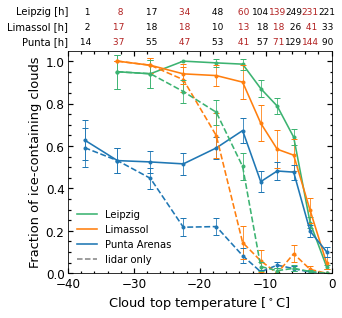

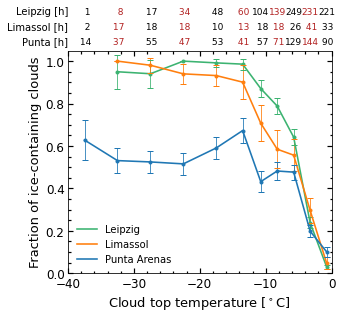

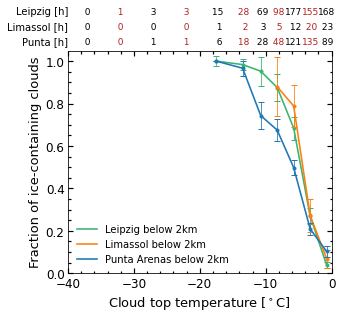

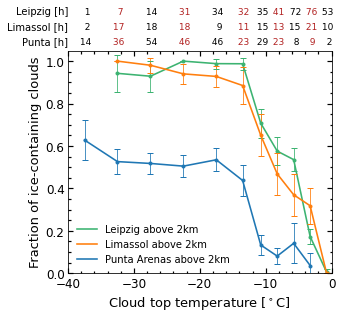

In [26]:

for which in ['hogan_all', 'all', 'coupled', 'uncoupled']:
# for which in ['uncoupled']:
    fig, ax = plt.subplots(figsize=(4.8, 4.5))
    
    print('========= ', which, ' ============================')
    if 'all' in which:
        print('standard')
        stat_std = ice_containing_fraction(stat_le['clouds_standard'])
        ax.plot(stat_std[0], stat_std[1], label='Leipzig', color='mediumseagreen', linewidth=1.6)
        ax.plot(stat_std[0], stat_std[1], '.', color='mediumseagreen')
        ax.errorbar(stat_std[0], stat_std[1], yerr=get_S2010_error(stat_le['clouds_standard']), 
                    lw=0,color='mediumseagreen', elinewidth=0.8, capsize=3)
        
        stat_std = ice_containing_fraction(stat_limassol['clouds_standard'])
        ax.plot(stat_std[0], stat_std[1], label='Limassol', color='C1', linewidth=1.6)
        ax.plot(stat_std[0], stat_std[1], '.', color='C1')
#         print('S10 err [pro]', 
#               np.sqrt(stat_std[1]*(1-stat_std[1])/(stat_std[2]+stat_std[3])))
        ax.errorbar(stat_std[0], stat_std[1], yerr=get_S2010_error(stat_limassol['clouds_standard']), 
                    lw=0, color='C1', elinewidth=0.8, capsize=3)
            
        stat_std = ice_containing_fraction(stat_punta['clouds_standard'])
        ax.plot(stat_std[0], stat_std[1], label='Punta Arenas', color='C0', linewidth=1.6)
        ax.plot(stat_std[0], stat_std[1], '.', color='C0')
        ax.errorbar(stat_std[0], stat_std[1], yerr=get_S2010_error(stat_punta['clouds_standard']), 
                    lw=0,color='C0', elinewidth=0.8, capsize=3)        
        
        if 'hogan' in which:
            print('hogan')
            stat_std = ice_containing_fraction(stat_punta['clouds_hogan'])
            ax.plot(stat_std[0], stat_std[1], '--', color='C0', linewidth=1.6)
            ax.plot(stat_std[0], stat_std[1], '.', color='C0')
            ax.errorbar(stat_std[0], stat_std[1], yerr=get_S2010_error(stat_punta['clouds_hogan']), 
                        lw=0,color='C0', elinewidth=0.8, capsize=3)  

            stat_std = ice_containing_fraction(stat_limassol['clouds_hogan'])
            ax.plot(stat_std[0], stat_std[1], '--', color='C1', linewidth=1.6)
            ax.plot(stat_std[0], stat_std[1], '.', color='C1')
            ax.errorbar(stat_std[0], stat_std[1], yerr=get_S2010_error(stat_limassol['clouds_hogan']), 
                        lw=0, color='C1', elinewidth=0.8, capsize=3)

            stat_std = ice_containing_fraction(stat_le['clouds_hogan'])
            ax.plot(stat_std[0], stat_std[1], '--', color='mediumseagreen', linewidth=1.6)
            ax.plot(stat_std[0], stat_std[1], '.', color='mediumseagreen')
            ax.errorbar(stat_std[0], stat_std[1], yerr=get_S2010_error(stat_le['clouds_hogan']), 
                        lw=0,color='mediumseagreen', elinewidth=0.8, capsize=3)
        
    elif which == 'coupled':
        stat_std = ice_containing_fraction(stat_le['clouds_below_cbh_thres'])
        ax.plot(stat_std[0], stat_std[1], label='Leipzig below 2km', color='mediumseagreen', linewidth=1.6)
        ax.plot(stat_std[0], stat_std[1], '.', color='mediumseagreen')
        ax.errorbar(stat_std[0], stat_std[1], yerr=get_S2010_error(stat_le['clouds_above_cbh_thres']), 
                    lw=0,color='mediumseagreen', elinewidth=0.8, capsize=3)
        
        stat_std = ice_containing_fraction(stat_limassol['clouds_below_cbh_thres'])
        ax.plot(stat_std[0], stat_std[1], label='Limassol below 2km', color='C1', linewidth=1.6)
        ax.plot(stat_std[0], stat_std[1], '.', color='C1')
        ax.errorbar(stat_std[0], stat_std[1], yerr=get_S2010_error(stat_limassol['clouds_below_cbh_thres']), 
                    lw=0, color='C1', elinewidth=0.8, capsize=3)
        
        stat_std = ice_containing_fraction(stat_punta['clouds_below_cbh_thres'])
        ax.plot(stat_std[0], stat_std[1], label='Punta Arenas below 2km', color='C0', linewidth=1.6)
        ax.plot(stat_std[0], stat_std[1], '.', color='C0')
        ax.errorbar(stat_std[0], stat_std[1], yerr=get_S2010_error(stat_punta['clouds_below_cbh_thres']), 
                    lw=0,color='C0', elinewidth=0.8, capsize=3)
        
    elif which == 'uncoupled':
        stat_std = ice_containing_fraction(stat_le['clouds_above_cbh_thres'])
        ax.plot(stat_std[0], stat_std[1], label='Leipzig above 2km', color='mediumseagreen', linewidth=1.6)
        ax.plot(stat_std[0], stat_std[1], '.', color='mediumseagreen')
        ax.errorbar(stat_std[0], stat_std[1], yerr=get_S2010_error(stat_le['clouds_above_cbh_thres']), 
                    lw=0,color='mediumseagreen', elinewidth=0.8, capsize=3)
        
        stat_std = ice_containing_fraction(stat_limassol['clouds_above_cbh_thres'])
        ax.plot(stat_std[0], stat_std[1], label='Limassol above 2km', color='C1', linewidth=1.6)
        ax.plot(stat_std[0], stat_std[1], '.', color='C1')
#         stat_std = ice_containing_fraction(stat_limassol['clouds_above_and_hogan'])
#         ax.plot(stat_std[0], stat_std[1], label='Punta + lidar detection thres', color='C6', linewidth=1.6)
        ax.errorbar(stat_std[0], stat_std[1], yerr=get_S2010_error(stat_limassol['clouds_above_cbh_thres']), 
                    lw=0, color='C1', elinewidth=0.8, capsize=3)
    
        stat_std = ice_containing_fraction(stat_punta['clouds_above_cbh_thres'])
        ax.plot(stat_std[0], stat_std[1], label='Punta Arenas above 2km', color='C0', linewidth=1.6)
        ax.plot(stat_std[0], stat_std[1], '.', color='C0')
#         stat_std = ice_containing_fraction(stat_punta['clouds_above_and_hogan'])
#         ax.plot(stat_std[0], stat_std[1], '--', color='C0', linewidth=1.6)
#         ax.plot(stat_std[0], stat_std[1], '.', color='C0')
        ax.errorbar(stat_std[0], stat_std[1], yerr=get_S2010_error(stat_punta['clouds_above_cbh_thres']), 
                    lw=0,color='C0', elinewidth=0.8, capsize=3)

        
    handles, labels = ax.get_legend_handles_labels()
    #if which == 'all' or which == 'uncoupled':
    if 'hogan' in which:
        # manually define a new patch 
        patch = matplotlib.lines.Line2D([0], [0], color='grey', linestyle='--', label='lidar only')
        # handles is a list, so append manual patch
        handles.append(patch) 

        
    ax.set_ylabel("Fraction of ice-containing clouds", fontsize=13)
    ax.set_xlabel("Cloud top temperature [$^\circ$C]", fontsize=13)
    ax.set_ylim([0,1.05])
    ax.set_xlim([-40, 0])
    ax.legend(handles=handles, framealpha=0)

    ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
    ax.tick_params(axis='both', which='major', direction='in',
                   top=True, right=True,
                   width=1.2, length=5, labelsize=12)
    ax.tick_params(axis='both', which='minor', direction='in', 
                   top=True, right=True,
                   width=1.2, length=2.5)


    # add the table with the number of cases
    #
    plt.tight_layout(rect=[0.05,0,1,0.87])
    ax.text(-40, 1.22, 'Leipzig [h]', horizontalalignment='right')
    ax.text(-40, 1.15, 'Limassol [h]', horizontalalignment='right')
    ax.text(-40, 1.08, 'Punta [h]', horizontalalignment='right')
    rename = {'all': 'clouds_standard', 
              'hogan_all': 'clouds_standard', 
              'coupled': 'clouds_below_cbh_thres', 
              'uncoupled': 'clouds_above_cbh_thres'}
    
    stat = ice_containing_fraction(stat_le[rename[which]], verbose=False)
    le_no = np.array(stat[2]) + np.array(stat[3])
    stat = ice_containing_fraction(stat_limassol[rename[which]], verbose=False)
    lim_no = np.array(stat[2]) + np.array(stat[3])
    stat = ice_containing_fraction(stat_punta[rename[which]], verbose=False)
    pun_no = np.array(stat[2]) + np.array(stat[3])
        
    for i,t in np.ndenumerate(stat[0]):
        if not i[0]%2:
            c = 'black'
        else:
            c = 'firebrick'
        # /2 for 30sec interval
        ax.text(t, 1.22, "{:>3.0f}".format(le_no[i]/2/60), 
                color=c, horizontalalignment='center', fontsize=9)
        ax.text(t, 1.15, "{:>3.0f}".format(lim_no[i]/2/60), 
                color=c, horizontalalignment='center', fontsize=9)
        ax.text(t, 1.08, "{:>3.0f}".format(pun_no[i]/2/60), 
                color=c, horizontalalignment='center', fontsize=9)

    if season != 'all':
        fname = '../plots/comparison_weighted/Lim_Punta_fraction_icecont_profile_{}_{}_small'.format(which, season)
    else:
        fname = '../plots/comparison_weighted/Lim_Punta_fraction_icecont_profile_{}_small'.format(which)
#         fname = '../plots/comparison_weighted/Lim_Punta_fraction_icecont_profile_nohogan_{}_small'.format(which)
    plt.savefig(fname+".png", dpi=250)
    #plt.savefig(fname+".svg", dpi=250)



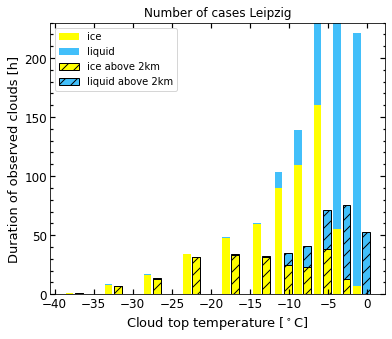

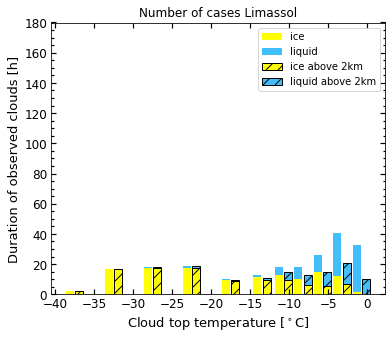

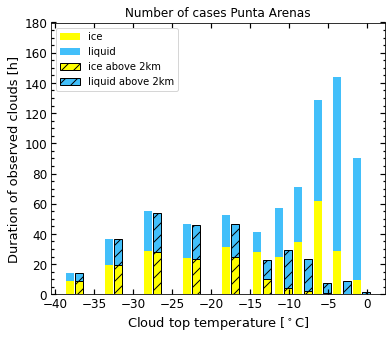

In [27]:
fig, ax = plt.subplots(figsize=(6, 5))
stat_std = ice_containing_fraction(stat_le["clouds_standard"], verbose=False)
ax.bar(stat_std[0]-0.6, stat_std[2]/2/60, width=1, label='ice', color='yellow')
ax.bar(stat_std[0]-0.6, stat_std[3]/2/60, width=1, bottom=stat_std[2]/2/60, label='liquid', color=(0.26, 0.75, 0.98))

stat_std = ice_containing_fraction(stat_le["clouds_above_cbh_thres"], verbose=False)
ax.bar(stat_std[0]+0.6, stat_std[2]/2/60, width=1, label='ice above 2km', 
       color='yellow', edgecolor='black', hatch="//")
ax.bar(stat_std[0]+0.6, stat_std[3]/2/60, width=1, bottom=stat_std[2]/2/60, label='liquid above 2km', 
       color=(0.26, 0.75, 0.98), edgecolor='black', hatch="//")

ax.set_title("Number of cases Leipzig")
ax.set_ylabel("Duration of observed clouds [h]", fontsize=13)
ax.set_xlabel("Cloud top temperature [$^\circ$C]", fontsize=13)
ax.set_ylim([0,230])

ax.legend()

#ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
ax.tick_params(axis='both', which='major', direction='in',
               top=True, right=True,
               width=1.2, length=5, labelsize=12)
ax.tick_params(axis='both', which='minor', direction='in', 
               top=True, right=True,
               width=1.2, length=2.5)

fname = '../plots/comparison_weighted/Le_no_cases'
plt.savefig(fname+'.png', dpi=250)


fig, ax = plt.subplots(figsize=(6, 5))
stat_std = ice_containing_fraction(stat_limassol["clouds_standard"], verbose=False)
ax.bar(stat_std[0]-0.6, stat_std[2]/2/60, width=1, label='ice', color='yellow')
ax.bar(stat_std[0]-0.6, stat_std[3]/2/60, width=1, bottom=stat_std[2]/2/60, label='liquid', color=(0.26, 0.75, 0.98))

stat_std = ice_containing_fraction(stat_limassol["clouds_above_cbh_thres"], verbose=False)
ax.bar(stat_std[0]+0.6, stat_std[2]/2/60, width=1, label='ice above 2km', 
       color='yellow', edgecolor='black', hatch="//")
ax.bar(stat_std[0]+0.6, stat_std[3]/2/60, width=1, bottom=stat_std[2]/2/60, label='liquid above 2km', 
       color=(0.26, 0.75, 0.98), edgecolor='black', hatch="//")

ax.set_title("Number of cases Limassol")
ax.set_ylabel("Duration of observed clouds [h]", fontsize=13)
ax.set_xlabel("Cloud top temperature [$^\circ$C]", fontsize=13)
ax.set_ylim([0,180])

ax.legend()

#ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
ax.tick_params(axis='both', which='major', direction='in',
               top=True, right=True,
               width=1.2, length=5, labelsize=12)
ax.tick_params(axis='both', which='minor', direction='in', 
               top=True, right=True,
               width=1.2, length=2.5)

fname = '../plots/comparison_weighted/Lim_no_cases'
plt.savefig(fname+'.png', dpi=250)
#plt.savefig(fname+'.svg', dpi=250)


fig, ax = plt.subplots(figsize=(6, 5))
stat_std = ice_containing_fraction(stat_punta["clouds_standard"], verbose=False)
ax.bar(stat_std[0]-0.6, stat_std[2]/2/60, width=1, label='ice', color='yellow')
ax.bar(stat_std[0]-0.6, stat_std[3]/2/60, width=1, bottom=stat_std[2]/2/60, label='liquid', color=(0.26, 0.75, 0.98))

stat_std = ice_containing_fraction(stat_punta['clouds_above_cbh_thres'], verbose=False)
ax.bar(stat_std[0]+0.6, stat_std[2]/2/60, width=1, label='ice above 2km', 
       color='yellow', edgecolor='black', hatch="//")
ax.bar(stat_std[0]+0.6, stat_std[3]/2/60, width=1, bottom=stat_std[2]/2/60, label='liquid above 2km', 
       color=(0.26, 0.75, 0.98), edgecolor='black', hatch="//")

ax.set_title("Number of cases Punta Arenas")
ax.set_ylabel("Duration of observed clouds [h]", fontsize=13)
ax.set_xlabel("Cloud top temperature [$^\circ$C]", fontsize=13)
ax.set_ylim([0,180])
ax.legend()

#ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
ax.tick_params(axis='both', which='major', direction='in',
               top=True, right=True,
               width=1.2, length=5, labelsize=12)
ax.tick_params(axis='both', which='minor', direction='in', 
               top=True, right=True,
               width=1.2, length=2.5)

fname = '../plots/comparison_weighted/Pun_no_cases'
plt.savefig(fname+'.png', dpi=250)
#plt.savefig(fname+'.svg', dpi=250)

In [28]:
alpha_liq = [float(c['alpha_Hogan_MED']) for c in stat_punta['clouds_above_and_hogan']['liquid_only']]
print('alpha_liq', min(alpha_liq), max(alpha_liq))

alpha_ice = [float(c['alpha_Hogan_MED']) for c in stat_punta['clouds_above_and_hogan']['ice_producing']]
print('alpha_ice', min(alpha_ice), max(alpha_ice))

#alpha_Hogan_AVG
#alpha_Hogan_MED


alpha_liq = [float(c['alpha_Hogan_MED']) for c in stat_le['clouds_above_and_hogan']['liquid_only']]
print('alpha_liq', min(alpha_liq), max(alpha_liq))

alpha_ice = [float(c['alpha_Hogan_MED']) for c in stat_le['clouds_above_and_hogan']['ice_producing']]
print('alpha_ice', min(alpha_ice), max(alpha_ice))


alpha_liq 0.0 6.087731705056952e-05
alpha_ice 1.2065203522530555e-05 0.00043667538286540244
alpha_liq 0.0 4.581114222748281e-05
alpha_ice 1.1838717683983315e-05 0.00218568550649515


In [29]:
#stat_punta_6e4 = make_kanitz_stat(clouds_punta, autocorr_thres=6e4, silent=True)
#stat_punta_1e4 = make_kanitz_stat(clouds_punta, autocorr_thres=1e4, silent=True)
stat_punta_3e4 = make_kanitz_stat(clouds_punta, autocorr_thres=3e4, silent=True)

# stat_punta_6e3 = make_kanitz_stat(clouds_punta, autocorr_thres=6e3, silent=True)
# stat_punta_3e3 = make_kanitz_stat(clouds_punta, autocorr_thres=3e3, silent=True)
stat_punta_1e3 = make_kanitz_stat(clouds_punta, autocorr_thres=1e3, silent=True)
stat_punta_6e2 = make_kanitz_stat(clouds_punta, autocorr_thres=6e2, silent=True)
# 2021-01-17: switched from 7e1 to 1e2
# stat_punta_1e2 = make_kanitz_stat(clouds_punta, autocorr_thres=1e2, silent=True)

not wave


<ipython-input-25-ddd2154ecaad>:26: RuntimeWarning: invalid value encountered in true_divide
  fraction = no_ice/(no_liq+no_ice)
<ipython-input-25-ddd2154ecaad>:51: RuntimeWarning: invalid value encountered in true_divide
  return centers, no_ice/(no_liq+no_ice), no_ice, no_liq


bins lower    -40.0 -35.0 -30.0 -25.0 -20.0 -15.0 -12.0  -9.5  -7.0  -4.5  -2.0
prof_liquid       0     0     0     0    48     0   905  1744  5032 10991 13162
prof_ice          0   626   761  1557  3043  2815  6379  8186 12159  3748   743
bins lower    -40.0 -35.0 -30.0 -25.0 -20.0 -15.0 -12.0  -9.5  -7.0  -4.5  -2.0
counts liq        0     0     0     0     1     0    12    18    44    94   118
counts ice        0     7    10    15    25    27    45    54    43    21     5
S10 err [no]    nan  0.00  0.00  0.00  0.04  0.00  0.05  0.05  0.05  0.04  0.02
bins lower    -40.0 -35.0 -30.0 -25.0 -20.0 -15.0 -12.0  -9.5  -7.0  -4.5  -2.0
prof_liquid       0     0     0   133    82   151   627   885  1212  3324  3747
prof_ice         45  1846  1884  2084  1069  1328  1517  1247  1760  1443   190
bins lower    -40.0 -35.0 -30.0 -25.0 -20.0 -15.0 -12.0  -9.5  -7.0  -4.5  -2.0
counts liq        0     0     0     2     1     3    12    17    18    43    55
counts ice        1    24    23    26   

<ipython-input-25-ddd2154ecaad>:26: RuntimeWarning: invalid value encountered in true_divide
  fraction = no_ice/(no_liq+no_ice)


../plots/comparison_weighted/Lim_Punta_fraction_icecont_profile_wavethresholds_small


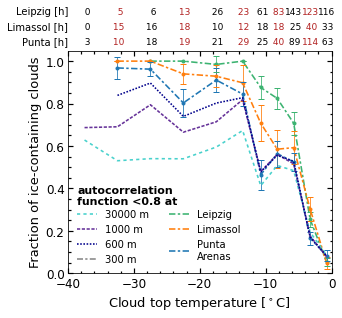

In [30]:


fig, ax = plt.subplots(figsize=(4.8, 4.5))

# stat_std = ice_containing_fraction(stat_le['not_wave'])
# ax.plot(stat_std[0], stat_std[1], label='Leipzig all', color='mediumseagreen', linewidth=1.6)
# ax.plot(stat_std[0], stat_std[1], '.', color='mediumseagreen')

print("not wave")
stat_std = ice_containing_fraction(stat_le['not_wave'])
ax.plot(stat_std[0], stat_std[1], ls=(0, (4, 1.5, 1.5, 1.5)), label='Leipzig', color='mediumseagreen', linewidth=1.6)
ax.plot(stat_std[0], stat_std[1], '.', color='mediumseagreen')
ax.errorbar(stat_std[0], stat_std[1], yerr=get_S2010_error(stat_le['not_wave']), 
            lw=0,color='mediumseagreen', elinewidth=0.8, capsize=3)

stat_std = ice_containing_fraction(stat_limassol['not_wave'])
ax.plot(stat_std[0], stat_std[1], ls=(0, (4, 1.5, 1.5, 1.5)), label='Limassol', color='C1', linewidth=1.6)
ax.plot(stat_std[0], stat_std[1], '.', color='C1')
ax.errorbar(stat_std[0], stat_std[1], yerr=get_S2010_error(stat_limassol['not_wave']), 
            lw=0,color='C1', elinewidth=0.8, capsize=3)

stat_std = ice_containing_fraction(stat_punta['not_wave'])
ax.plot(stat_std[0], stat_std[1], ls=(0, (4, 1.5, 1.5, 1.5)), label='Punta\nArenas', color='C0', linewidth=1.6)
ax.plot(stat_std[0], stat_std[1], '.', color='C0')
ax.errorbar(stat_std[0], stat_std[1], yerr=get_S2010_error(stat_punta['not_wave']), 
            lw=0,color='C0', elinewidth=0.8, capsize=3)



print('--------------------------------------------')
# print('punta 6e4')
# stat_std = ice_containing_fraction(stat_punta_6e4['not_wave'])
# ax.plot(stat_std[0], stat_std[1], ':', label='6e4 m', color='mediumturquoise', linewidth=1.6)
# print('punta 1e4')
# stat_std = ice_containing_fraction(stat_punta_1e4['not_wave'])
# ax.plot(stat_std[0], stat_std[1], ':', label='1e4 m', color='deepskyblue', linewidth=1.6)
print('punta 3e4')
stat_std = ice_containing_fraction(stat_punta_3e4['not_wave'])
ax.plot(stat_std[0], stat_std[1], ls=(0, (2, 2)), label='30000 m', color='mediumturquoise', linewidth=1.6)
# print('punta 6e3')
# stat_std = ice_containing_fraction(stat_punta_6e3['not_wave'])
# ax.plot(stat_std[0], stat_std[1], ':', label='6e3 m', color='royalblue', linewidth=1.6)
# print('punta 3e3')
# stat_std = ice_containing_fraction(stat_punta_3e3['not_wave'])
# ax.plot(stat_std[0], stat_std[1], ':', label='3e3 m', color='slateblue', linewidth=1.6)
print('punta 1e3')
stat_std = ice_containing_fraction(stat_punta_1e3['not_wave'])
ax.plot(stat_std[0], stat_std[1], ls=(0, (2, 1)), label='1000 m', color='rebeccapurple', linewidth=1.6)
print('punta 6e2')
stat_std = ice_containing_fraction(stat_punta_6e2['not_wave'])
ax.plot(stat_std[0], stat_std[1], ls=(0, (1, 1)), label='600 m', color='darkblue', linewidth=1.6)

# print('punta 1e2')
# stat_std = ice_containing_fraction(stat_punta_1e2['not_wave'])
# ax.plot(stat_std[0], stat_std[1], ':', label='1e2 m', color='darkorchid', linewidth=1.6)


print('--------------------------------------------')

ax.set_ylabel("Fraction of ice-containing clouds", fontsize=13)
ax.set_xlabel("Cloud top temperature [$^\circ$C]", fontsize=13)
ax.set_ylim([0,1.05])
ax.set_xlim([-40, 0])
#ax.legend(handles=handles, framealpha=0)
handles, labels = ax.get_legend_handles_labels()
# manually define a new patch 
patch = matplotlib.lines.Line2D([0], [0], color='grey', linestyle=(0, (4, 1.5, 1.5, 1.5)), label='300 m')
# handles is a list, so append manual patch
handles.append(patch)
handles = handles[3:] + handles[:3]
ax.legend(handles=handles, framealpha=0, ncol=2, handlelength=2.0)

ax.text(0.035, 0.3, 'autocorrelation\nfunction <0.8 at', horizontalalignment='left',
        verticalalignment='bottom', 
        transform=ax.transAxes, color='k', fontsize=11, fontweight='semibold')


ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
ax.tick_params(axis='both', which='major', direction='in',
               top=True, right=True,
               width=1.2, length=5, labelsize=12)
ax.tick_params(axis='both', which='minor', direction='in', 
               top=True, right=True,
               width=1.2, length=2.5)


# add the table with the number of cases
#
plt.tight_layout(rect=[0.05,0,1,0.87])
# # ax.text(-40, 1.22, 'Leipzig [h]', horizontalalignment='right')
# ax.text(-40, 1.15, 'Limassol [h]', horizontalalignment='right')
# ax.text(-40, 1.08, 'Punta [h]', horizontalalignment='right')

# # stat = ice_containing_fraction(stat_le[rename[which]])
# # le_no = np.array(stat[2]) + np.array(stat[3])
# stat = ice_containing_fraction(stat_limassol['not_wave'])
# lim_no = np.array(stat[2]) + np.array(stat[3])
# stat = ice_containing_fraction(stat_punta['not_wave'])
# pun_no = np.array(stat[2]) + np.array(stat[3])

# for i,t in np.ndenumerate(stat[0]):
#     if not i[0]%2:
#         c = 'black'
#     else:
#         c = 'firebrick'
#     # /2 for 30sec interval
# #     ax.text(t, 1.22, "{:>3.0f}".format(le_no[i]/2/60), color=c, horizontalalignment='center')
#     ax.text(t, 1.15, "{:>3.0f}".format(lim_no[i]/2/60), color=c, horizontalalignment='center')
#     ax.text(t, 1.08, "{:>3.0f}".format(pun_no[i]/2/60), color=c, horizontalalignment='center')

    
ax.text(-40, 1.22, 'Leipzig [h]', horizontalalignment='right')
ax.text(-40, 1.15, 'Limassol [h]', horizontalalignment='right')
ax.text(-40, 1.08, 'Punta [h]', horizontalalignment='right')

stat = ice_containing_fraction(stat_le['not_wave'], verbose=False)
le_no = np.array(stat[2]) + np.array(stat[3])
stat = ice_containing_fraction(stat_limassol['not_wave'], verbose=False)
lim_no = np.array(stat[2]) + np.array(stat[3])
stat = ice_containing_fraction(stat_punta['not_wave'], verbose=False)
pun_no = np.array(stat[2]) + np.array(stat[3])


for i,t in np.ndenumerate(stat[0]):
    if not i[0]%2:
        c = 'black'
    else:
        c = 'firebrick'
    # /2 for 30sec interval
    ax.text(t, 1.22, "{:>3.0f}".format(le_no[i]/2/60), 
            color=c, horizontalalignment='center', fontsize=9)
    ax.text(t, 1.15, "{:>3.0f}".format(lim_no[i]/2/60), 
            color=c, horizontalalignment='center', fontsize=9)
    ax.text(t, 1.08, "{:>3.0f}".format(pun_no[i]/2/60), 
            color=c, horizontalalignment='center', fontsize=9)

fname = '../plots/comparison_weighted/Lim_Punta_fraction_icecont_profile_wavethresholds_small'
print(fname)
plt.savefig(fname+".png", dpi=250)
#plt.savefig(fname+".svg", dpi=250)


coupled
bins lower    -40.0 -35.0 -30.0 -25.0 -20.0 -15.0 -12.0  -9.5  -7.0  -4.5  -2.0
prof_liquid       0     0     0     0     0    55   393  1469  6722 13585 19395
prof_ice          0   129   332   345  1747  3323  7884 10339 14575  5030   778
bins lower    -40.0 -35.0 -30.0 -25.0 -20.0 -15.0 -12.0  -9.5  -7.0  -4.5  -2.0
counts liq        0     0     0     0     0     1     5    15    51    86   144
counts ice        0     1     3     4    13    17    53    64    60    27     5
S10 err [no]    nan  0.00  0.00  0.00  0.00  0.05  0.04  0.04  0.05  0.04  0.01
bins lower    -40.0 -35.0 -30.0 -25.0 -20.0 -15.0 -12.0  -9.5  -7.0  -4.5  -2.0
prof_liquid       0     0     0     0     0     0     0    73   298  1715  2548
prof_ice          0     0     0     0    68   211   349   531  1112   643   190
bins lower    -40.0 -35.0 -30.0 -25.0 -20.0 -15.0 -12.0  -9.5  -7.0  -4.5  -2.0
counts liq        0     0     0     0     0     0     0     2     5    24    36
counts ice        0     0     0 

<ipython-input-25-ddd2154ecaad>:26: RuntimeWarning: invalid value encountered in true_divide
  fraction = no_ice/(no_liq+no_ice)
<ipython-input-25-ddd2154ecaad>:51: RuntimeWarning: invalid value encountered in true_divide
  return centers, no_ice/(no_liq+no_ice), no_ice, no_liq
<ipython-input-25-ddd2154ecaad>:26: RuntimeWarning: invalid value encountered in true_divide
  fraction = no_ice/(no_liq+no_ice)
<ipython-input-25-ddd2154ecaad>:51: RuntimeWarning: invalid value encountered in true_divide
  return centers, no_ice/(no_liq+no_ice), no_ice, no_liq
<ipython-input-25-ddd2154ecaad>:26: RuntimeWarning: invalid value encountered in true_divide
  fraction = no_ice/(no_liq+no_ice)
<ipython-input-25-ddd2154ecaad>:51: RuntimeWarning: invalid value encountered in true_divide
  return centers, no_ice/(no_liq+no_ice), no_ice, no_liq


bins lower    -40.0 -35.0 -30.0 -25.0 -20.0 -15.0 -12.0  -9.5  -7.0  -4.5  -2.0
prof_liquid       0    50   121     0    48    48  1212  2063  3990  7535  6306
prof_ice         84   819  1581  3746  4005  3817  2932  2802  4605  1579    36
bins lower    -40.0 -35.0 -30.0 -25.0 -20.0 -15.0 -12.0  -9.5  -7.0  -4.5  -2.0
counts liq        0     1     3     0     1     1    15    27    49    90    79
counts ice        2    10    19    33    41    35    31    31    31    18     1
S10 err [no]   0.00  0.09  0.07  0.00  0.02  0.03  0.07  0.07  0.05  0.04  0.01
bins lower    -40.0 -35.0 -30.0 -25.0 -20.0 -15.0 -12.0  -9.5  -7.0  -4.5  -2.0
prof_liquid       0     0    42   133    82   151   627   812  1103  1713  1199
prof_ice        286  1982  2119  2084  1055  1163  1168   716   648   800     0
bins lower    -40.0 -35.0 -30.0 -25.0 -20.0 -15.0 -12.0  -9.5  -7.0  -4.5  -2.0
counts liq        0     0     1     2     1     3    12    15    15    20    19
counts ice        3    27    26    26   

<ipython-input-25-ddd2154ecaad>:26: RuntimeWarning: invalid value encountered in true_divide
  fraction = no_ice/(no_liq+no_ice)


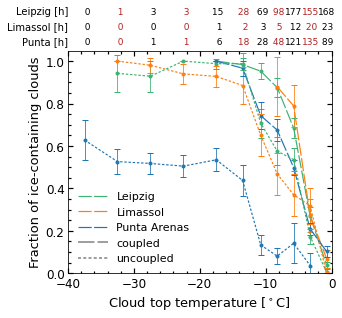

In [31]:

fig, ax = plt.subplots(figsize=(4.8, 4.5))


print('coupled')
stat_std = ice_containing_fraction(stat_le['clouds_below_cbh_thres'])
ax.plot(stat_std[0], stat_std[1], ls=(0, (11,2)), label='Leipzig', color='mediumseagreen', linewidth=1.2)
ax.plot(stat_std[0], stat_std[1], '.', color='mediumseagreen')
ax.errorbar(stat_std[0], stat_std[1], yerr=get_S2010_error(stat_le['clouds_below_cbh_thres']), 
            lw=0,color='mediumseagreen', elinewidth=0.8, capsize=3)

stat_std = ice_containing_fraction(stat_limassol['clouds_below_cbh_thres'])
ax.plot(stat_std[0], stat_std[1], ls=(0, (11,2)), label='Limassol', color='C1', linewidth=1.2)
ax.plot(stat_std[0], stat_std[1], '.', color='C1')
ax.errorbar(stat_std[0], stat_std[1], yerr=get_S2010_error(stat_limassol['clouds_below_cbh_thres']), 
            lw=0,color='C1', elinewidth=0.8, capsize=3)

stat_std = ice_containing_fraction(stat_punta['clouds_below_cbh_thres'])
ax.plot(stat_std[0], stat_std[1], ls=(0, (11,2)), label='Punta Arenas', color='C0', linewidth=1.2)
ax.plot(stat_std[0], stat_std[1], '.', color='C0')
ax.errorbar(stat_std[0], stat_std[1], yerr=get_S2010_error(stat_punta['clouds_below_cbh_thres']), 
            lw=0,color='C0', elinewidth=0.8, capsize=3)

print('uncouled')
stat_std = ice_containing_fraction(stat_le['clouds_above_cbh_thres'])
ax.plot(stat_std[0], stat_std[1], ls=(0, (2,1.5)), color='mediumseagreen', linewidth=1.2)
ax.plot(stat_std[0], stat_std[1], '.', color='mediumseagreen')
ax.errorbar(stat_std[0], stat_std[1], yerr=get_S2010_error(stat_le['clouds_above_cbh_thres']), 
            lw=0,color='mediumseagreen', elinewidth=0.8, capsize=3)

stat_std = ice_containing_fraction(stat_limassol['clouds_above_cbh_thres'])
ax.plot(stat_std[0], stat_std[1], ls=(0, (2,1.5)), color='C1', linewidth=1.2)
ax.plot(stat_std[0], stat_std[1], '.', color='C1')
ax.errorbar(stat_std[0], stat_std[1], yerr=get_S2010_error(stat_limassol['clouds_above_cbh_thres']), 
            lw=0,color='C1', elinewidth=0.8, capsize=3)

# stat_std = ice_containing_fraction(stat_limassol['clouds_above_and_hogan'])
# ax.plot(stat_std[0], stat_std[1], label='Punta + lidar detection thres', color='C6', linewidth=1.6)
stat_std = ice_containing_fraction(stat_punta['clouds_above_cbh_thres'])
ax.plot(stat_std[0], stat_std[1], ls=(0, (2,1.5)), color='C0', linewidth=1.2)
ax.plot(stat_std[0], stat_std[1], '.', color='C0')
ax.errorbar(stat_std[0], stat_std[1], yerr=get_S2010_error(stat_punta['clouds_above_cbh_thres']), 
            lw=0,color='C0', elinewidth=0.8, capsize=3)

# stat_std = ice_containing_fraction(stat_punta['clouds_above_and_hogan'])
# ax.plot(stat_std[0], stat_std[1], '--', color='C0', linewidth=1.6)
# ax.plot(stat_std[0], stat_std[1], '.', color='C0')


handles, labels = ax.get_legend_handles_labels()
#if which == 'all' or which == 'uncoupled':

# manually define a new patch 
# patch = matplotlib.lines.Line2D([0], [0], color='grey', linestyle='--', label='lidar only')
# # handles is a list, so append manual patch
# handles.append(patch) 
patch = matplotlib.lines.Line2D([0], [0], color='grey', linestyle=(0, (11,2)), label='coupled')
# handles is a list, so append manual patch
handles.append(patch) 
patch = matplotlib.lines.Line2D([0], [0], color='grey', linestyle=(0, (2,1.5)), label='uncoupled')
# handles is a list, so append manual patch
handles.append(patch) 


ax.set_ylabel("Fraction of ice-containing clouds", fontsize=13)
ax.set_xlabel("Cloud top temperature [$^\circ$C]", fontsize=13)
ax.set_ylim([0,1.05])
ax.set_xlim([-40, 0])
ax.legend(handles=handles, framealpha=0, ncol=1, fontsize=11, handlelength=2.7)

ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
ax.tick_params(axis='both', which='major', direction='in',
               top=True, right=True,
               width=1.2, length=5, labelsize=12)
ax.tick_params(axis='both', which='minor', direction='in', 
               top=True, right=True,
               width=1.2, length=2.5)


# add the table with the number of cases
#
plt.tight_layout(rect=[0.05,0,1,0.87])
ax.text(-40, 1.22, 'Leipzig [h]', horizontalalignment='right')
ax.text(-40, 1.15, 'Limassol [h]', horizontalalignment='right')
ax.text(-40, 1.08, 'Punta [h]', horizontalalignment='right')
rename = {'all': 'clouds_standard', 
          'coupled': 'clouds_below_cbh_thres', 
          'uncoupled': 'clouds_above_cbh_thres'}

stat = ice_containing_fraction(stat_le[rename['coupled']], verbose=False)
le_no = np.array(stat[2]) + np.array(stat[3])
stat = ice_containing_fraction(stat_limassol[rename['coupled']], verbose=False)
lim_no = np.array(stat[2]) + np.array(stat[3])
stat = ice_containing_fraction(stat_punta[rename['coupled']], verbose=False)
pun_no = np.array(stat[2]) + np.array(stat[3])

for i,t in np.ndenumerate(stat[0]):
    if not i[0]%2:
        c = 'black'
    else:
        c = 'firebrick'
    # /2 for 30sec interval
    ax.text(t, 1.22, "{:>3.0f}".format(le_no[i]/2/60), 
            color=c, horizontalalignment='center', fontsize=9)
    ax.text(t, 1.15, "{:>3.0f}".format(lim_no[i]/2/60), 
            color=c, horizontalalignment='center', fontsize=9)
    ax.text(t, 1.08, "{:>3.0f}".format(pun_no[i]/2/60), 
            color=c, horizontalalignment='center', fontsize=9)

if season != 'all':
    fname = '../plots/comparison_weighted/Lim_Punta_fraction_icecont_profile_both_{}_small'.format(season)
else:
    fname = '../plots/comparison_weighted/Lim_Punta_fraction_icecont_profile_both_small'

plt.savefig(fname+".png", dpi=250)
#plt.savefig(fname+".svg", dpi=250)



uncouled
bins lower    -40.0 -35.0 -30.0 -25.0 -20.0 -15.0 -12.0  -9.5  -7.0  -4.5  -2.0
prof_liquid       0     0     0     0    48     0   512  1115  1754  5307  3315
prof_ice          0   497   688  1332  2256  1690  1032  1899  2068   697    36
bins lower    -40.0 -35.0 -30.0 -25.0 -20.0 -15.0 -12.0  -9.5  -7.0  -4.5  -2.0
counts liq        0     1     3     0     1     1    15    27    49    90    79
counts ice        2    10    19    33    41    35    31    31    31    18     1
S10 err [no]   0.00  0.09  0.07  0.00  0.02  0.03  0.07  0.07  0.05  0.04  0.01
bins lower    -40.0 -35.0 -30.0 -25.0 -20.0 -15.0 -12.0  -9.5  -7.0  -4.5  -2.0
prof_liquid       0     0     0   133    82   151   627   812   914  1609  1199
prof_ice         45  1846  1884  2084  1001  1117  1168   716   648   800     0
bins lower    -40.0 -35.0 -30.0 -25.0 -20.0 -15.0 -12.0  -9.5  -7.0  -4.5  -2.0
counts liq        0     0     1     2     1     3    12    15    15    20    19
counts ice        3    27    26

<ipython-input-25-ddd2154ecaad>:26: RuntimeWarning: invalid value encountered in true_divide
  fraction = no_ice/(no_liq+no_ice)
<ipython-input-25-ddd2154ecaad>:26: RuntimeWarning: invalid value encountered in true_divide
  fraction = no_ice/(no_liq+no_ice)
<ipython-input-25-ddd2154ecaad>:26: RuntimeWarning: invalid value encountered in true_divide
  fraction = no_ice/(no_liq+no_ice)


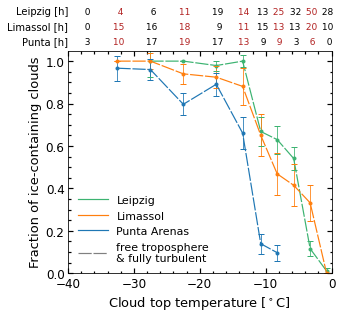

In [32]:
fig, ax = plt.subplots(figsize=(4.8, 4.5))

# print('coupled')
# stat_std = ice_containing_fraction(stat_le['clouds_below_cbh_thres'])
# ax.plot(stat_std[0], stat_std[1], ls=(0, (11,2)), label='Leipzig', color='mediumseagreen', linewidth=1.2)
# ax.plot(stat_std[0], stat_std[1], '.', color='mediumseagreen')
# ax.errorbar(stat_std[0], stat_std[1], yerr=get_S2010_error(stat_le['clouds_below_cbh_thres']), 
#             lw=0,color='mediumseagreen', elinewidth=0.8, capsize=3)

# stat_std = ice_containing_fraction(stat_limassol['clouds_below_cbh_thres'])
# ax.plot(stat_std[0], stat_std[1], ls=(0, (11,2)), label='Limassol', color='C1', linewidth=1.2)
# ax.plot(stat_std[0], stat_std[1], '.', color='C1')
# ax.errorbar(stat_std[0], stat_std[1], yerr=get_S2010_error(stat_limassol['clouds_below_cbh_thres']), 
#             lw=0,color='C1', elinewidth=0.8, capsize=3)

# stat_std = ice_containing_fraction(stat_punta['clouds_below_cbh_thres'])
# ax.plot(stat_std[0], stat_std[1], ls=(0, (11,2)), label='Punta Arenas', color='C0', linewidth=1.2)
# ax.plot(stat_std[0], stat_std[1], '.', color='C0')
# ax.errorbar(stat_std[0], stat_std[1], yerr=get_S2010_error(stat_punta['clouds_below_cbh_thres']), 
#             lw=0,color='C0', elinewidth=0.8, capsize=3)

print('uncouled')
stat_std = ice_containing_fraction(stat_le['not_wave_above_cbh'])
ax.plot(stat_std[0], stat_std[1], ls=(0, (11,1.5)), color='mediumseagreen', linewidth=1.2,)
ax.plot(stat_std[0], stat_std[1], '.', color='mediumseagreen')
ax.errorbar(stat_std[0], stat_std[1], yerr=get_S2010_error(stat_le['clouds_above_cbh_thres']), 
            lw=0,color='mediumseagreen', elinewidth=0.8, capsize=3)

stat_std = ice_containing_fraction(stat_limassol['not_wave_above_cbh'])
ax.plot(stat_std[0], stat_std[1], ls=(0, (11,1.5)), color='C1', linewidth=1.2)
ax.plot(stat_std[0], stat_std[1], '.', color='C1')
ax.errorbar(stat_std[0], stat_std[1], yerr=get_S2010_error(stat_limassol['clouds_above_cbh_thres']), 
            lw=0,color='C1', elinewidth=0.8, capsize=3)

# stat_std = ice_containing_fraction(stat_limassol['clouds_above_and_hogan'])
# ax.plot(stat_std[0], stat_std[1], label='Punta + lidar detection thres', color='C6', linewidth=1.6)
stat_std = ice_containing_fraction(stat_punta['not_wave_above_cbh'])
ax.plot(stat_std[0][:-2], stat_std[1][:-2], ls=(0, (11,1.5)), color='C0', linewidth=1.2)
ax.plot(stat_std[0][:-2], stat_std[1][:-2], '.', color='C0')
ax.errorbar(stat_std[0][:-2], stat_std[1][:-2], yerr=get_S2010_error(stat_punta['clouds_above_cbh_thres'])[:-2], 
            lw=0,color='C0', elinewidth=0.8, capsize=3)

# stat_std = ice_containing_fraction(stat_punta['clouds_above_and_hogan'])
# ax.plot(stat_std[0], stat_std[1], '--', color='C0', linewidth=1.6)
# ax.plot(stat_std[0], stat_std[1], '.', color='C0')


handles, labels = ax.get_legend_handles_labels()
#if which == 'all' or which == 'uncoupled':

patch = matplotlib.lines.Line2D([0], [0], color='mediumseagreen', lw=1.2, label='Leipzig')
handles.append(patch) 
patch = matplotlib.lines.Line2D([0], [0], color='C1', lw=1.2, label='Limassol')
handles.append(patch) 
patch = matplotlib.lines.Line2D([0], [0], color='C0', lw=1.2, label='Punta Arenas')
handles.append(patch) 
# manually define a new patch 
# patch = matplotlib.lines.Line2D([0], [0], color='grey', linestyle='--', label='lidar only')
# handles.append(patch) 
#patch = matplotlib.lines.Line2D([0], [0], color='grey', linestyle=(0, (11,2)), label='coupled')
#handles.append(patch) 
patch = matplotlib.lines.Line2D([0], [0], color='grey', linestyle=(0, (11,1.5)),
                                lw=1.2,
                                label='free troposphere\n& fully turbulent')

handles.append(patch) 


ax.set_ylabel("Fraction of ice-containing clouds", fontsize=13)
ax.set_xlabel("Cloud top temperature [$^\circ$C]", fontsize=13)
ax.set_ylim([0,1.05])
ax.set_xlim([-40, 0])
ax.legend(handles=handles, framealpha=0, ncol=1, fontsize=11, handlelength=2.7)

ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
ax.tick_params(axis='both', which='major', direction='in',
               top=True, right=True,
               width=1.2, length=5, labelsize=12)
ax.tick_params(axis='both', which='minor', direction='in', 
               top=True, right=True,
               width=1.2, length=2.5)


# add the table with the number of cases
#
plt.tight_layout(rect=[0.05,0,1,0.87])
ax.text(-40, 1.22, 'Leipzig [h]', horizontalalignment='right')
ax.text(-40, 1.15, 'Limassol [h]', horizontalalignment='right')
ax.text(-40, 1.08, 'Punta [h]', horizontalalignment='right')
rename = {'all': 'clouds_standard', 
          'coupled': 'clouds_below_cbh_thres', 
          'uncoupled': 'not_wave_above_cbh'}

stat = ice_containing_fraction(stat_le[rename['uncoupled']], verbose=False)
le_no = np.array(stat[2]) + np.array(stat[3])
stat = ice_containing_fraction(stat_limassol[rename['uncoupled']], verbose=False)
lim_no = np.array(stat[2]) + np.array(stat[3])
stat = ice_containing_fraction(stat_punta[rename['uncoupled']], verbose=False)
pun_no = np.array(stat[2]) + np.array(stat[3])

for i,t in np.ndenumerate(stat[0]):
    if not i[0]%2:
        c = 'black'
    else:
        c = 'firebrick'
    # /2 for 30sec interval
    ax.text(t, 1.22, "{:>3.0f}".format(le_no[i]/2/60), 
            color=c, horizontalalignment='center', fontsize=9)
    ax.text(t, 1.15, "{:>3.0f}".format(lim_no[i]/2/60), 
            color=c, horizontalalignment='center', fontsize=9)
    ax.text(t, 1.08, "{:>3.0f}".format(pun_no[i]/2/60), 
            color=c, horizontalalignment='center', fontsize=9)

if season != 'all':
    fname = '../plots/comparison_weighted/Lim_Punta_fraction_icecont_profile_nowave_abovecbh_{}_small'.format(season)
else:
    fname = '../plots/comparison_weighted/Lim_Punta_fraction_icecont_profile_nowave_abovecbh_small'

plt.savefig(fname+".png", dpi=250)
#plt.savefig(fname+".svg", dpi=250)